In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import math
from keras import backend as K
from tensorflow.keras import layers, regularizers

sns.set(style="darkgrid", font_scale=1.2)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
chart = pd.read_csv('drive/My Drive/NN_Assignment/btc.csv')

In [ ]:
# view top values in the chart
chart.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,16/7/2010,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,17/7/2010,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,18/7/2010,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,19/7/2010,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,20/7/2010,0.07474,0.07921,0.06634,0.07921,0.07921,42


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7cc14c0160>],
      dtype=object)

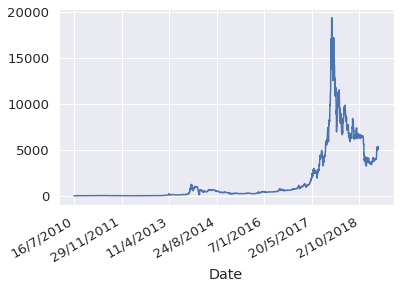

In [ ]:
# plot graph
close_data = chart['Close']
close_data.index = chart['Date']
close_data.plot(subplots=True)

In [ ]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
close_price = close_data.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [ ]:
# check for NaN values
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
# process and window data
def window_data(data, window_size):
  X =[]
  y=[]

  i = 0
  while(i + window_size) <= len(data) - 1:   
    X.append(data[i:(i+window_size)])
    y.append(data[i+window_size])
    i += 1
  assert len(X) == len(y)
  return X, y

In [ ]:
window_size = 7
X, y = window_data(scaled_close, window_size)

In [ ]:
# get length of 90% of training data
train_len = math.ceil(len(X)*0.9)

# split data into training and testing set
x_train = X[:train_len]
y_train = y[:train_len]
x_test = X[train_len:]
y_test = y[train_len:]

In [ ]:
# convert lists to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
# function to plot history and model prediction
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
# single prediction based on the mean
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

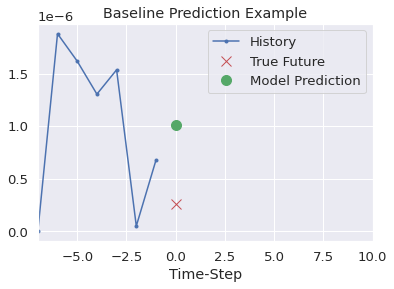

In [ ]:
show_plot([x_train[0], y_train[0], baseline(x_train[0])], 0,
          'Baseline Prediction Example')

In [ ]:
# function to calculate root mean squared error
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
# define model, units = number of LSTM memory cell
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(window_size,1)))
model.add(layers.LSTM(units=32, dropout=0.2, activity_regularizer = regularizers.l2(0.001)))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 3, 256)            264192    
_________________________________________________________________
lstm_92 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
model.compile(optimizer='adam', loss=root_mean_squared_error)
history = model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0285
Epoch 2/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0154
Epoch 3/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0153
Epoch 4/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0145
Epoch 5/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0159
Epoch 6/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0162
Epoch 7/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0150
Epoch 8/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0148
Epoch 9/30
90/90 [==============================] - 3s 32ms/step - loss: 0.0134
Epoch 10/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0130
Epoch 11/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0130
Epoch 12/30
90/90 [==============================] - 3s 33ms/step - loss: 0.0128
Epoch 13/30
90/90 [==================

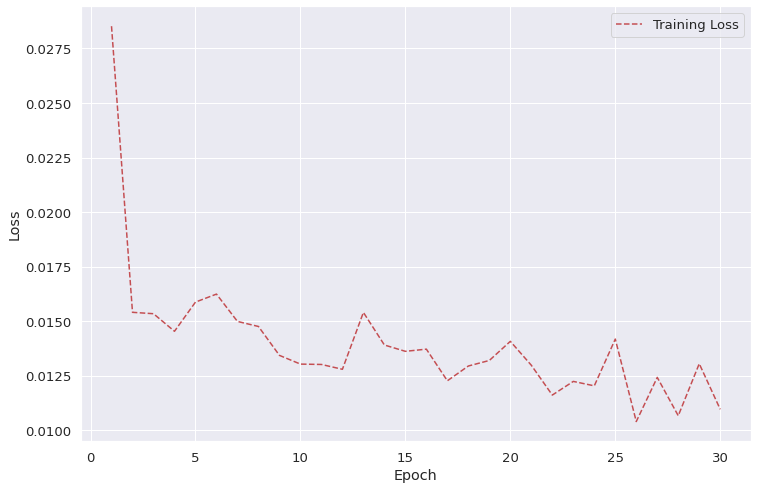

In [ ]:
# plot training loss graph
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

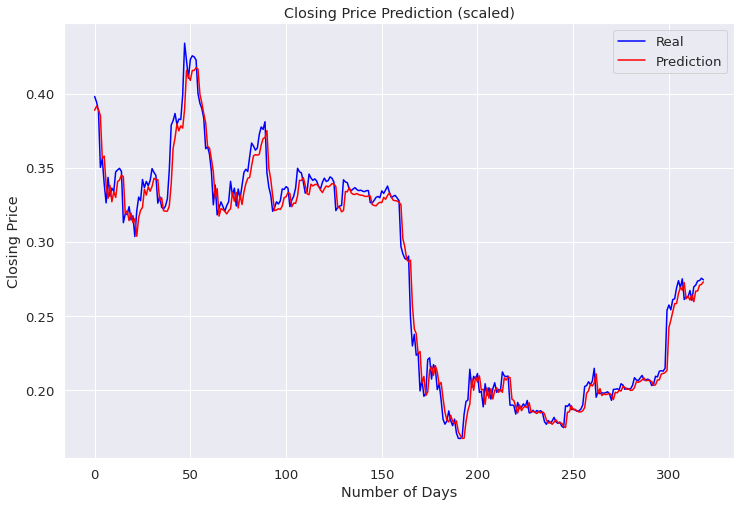

In [ ]:
# make prediction and plotting in a graph
pred = model.predict(x_test)
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Closing Price Prediction (scaled)')
plt.ylabel('Closing Price')
plt.xlabel('Number of Days')
plt.legend()
plt.show()

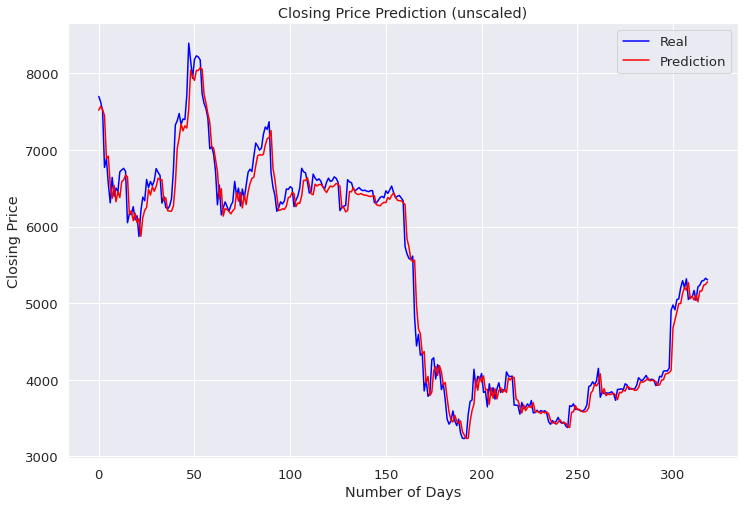

In [ ]:
# undo scaling for the data and plotting in a graph
y_test_inverse = scaler.inverse_transform(y_test)
pred_inverse = scaler.inverse_transform(pred)

plt.figure(figsize=(12,8))
plt.plot(y_test_inverse, color='blue', label='Real')
plt.plot(pred_inverse, color='red', label='Prediction')
plt.title('Closing Price Prediction (unscaled)')
plt.ylabel('Closing Price')
plt.xlabel('Number of Days')
plt.legend()
plt.show()